# Applying prophet to time series forecasting of Well and Riser flow rates

## Author: Ridha Alkhabaz


## Imports:


In [5]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [6]:
import sys
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os
import math
import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot, dates
from datetime import timedelta
from prophet import Prophet
from pandas import read_csv
from pandas import datetime
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import datetime as dttm

## Data configuration and readdings:


##### First the riser data needs some special reconfigurations:

In [3]:
# Convert the sequence of seconds into datetime array
def parser(x):
    now_seconds = 0
    y = x.astype(np.float) + now_seconds
    z = pd.to_datetime(y, unit='s')
    return z

In [4]:
# Read the data from fname and eventually plot them
def read_data(fname, plot_data = False):
    # Read the time series
    datats = read_csv(fname, header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

    headers = list(datats.columns.values)
    headers.insert(0, datats.index.name)
 
    # Resample the data using a uniform timestep
    datats = datats.resample('S').mean()
    datats = datats.interpolate(method='linear')
    # Convert data to numpy array
    data = datats.reset_index().values

    # Replace timestamps with seconds
    time_sec = array([data[i, 0].timestamp() for i in range(len(data))])
    data = np.c_[time_sec, data[:, 1:]]
        
        
    #Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(data)
    scaler.scale_[0] = 1    # Do not normalize time

    # Apply the same normalization to all pressure readings
    pind = list(range(1, 8))  # Indices of pressure readings
    pmin = scaler.data_min_[pind].min()
    pmax = scaler.data_max_[pind].max()
    scaler.scale_[pind] = ((scaler.feature_range[1] - scaler.feature_range[0]) / (pmax - pmin))
    scaler.min_[pind] = scaler.feature_range[0] - pmin * scaler.scale_[pind]

    data = scaler.transform(data)

    return data, scaler

## Deploying Prophet:
### The riser data set:

In [5]:
data, _= read_data('riser_pq_uni.csv')
dft = pd.DataFrame.from_dict(dict(zip(['ds', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7','gas(m3/day)', 'liquid(m3/day)' ], data.T)))
### univariate prophet 
train_uni = pd.concat([dft.iloc[:int(0.7*len(dft)), 0], dft.iloc[:int(0.7*len(dft)), 8:]], axis=1)
test_uni = pd.concat([dft.iloc[int(0.7*len(dft)):len(dft), 0], dft.iloc[int(0.7*len(dft)):len(dft), 8:]], axis=1)
### multivariate prophet 
train_mult = dft.iloc[:int(0.7*len(dft))]
test_mult = dft.iloc[int(0.7*len(dft)):len(dft)]

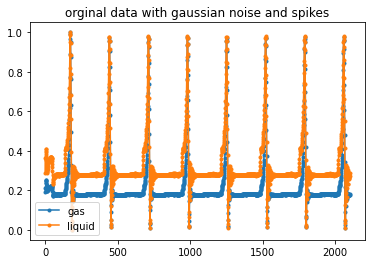

In [8]:
# some visualization
start_ploting = 0
end_ploting = len(train_mult)
fig,ax = plt.subplots()
ax.set_title('orginal data with gaussian noise and spikes')
ax.plot(train_mult['ds'].iloc[start_ploting:end_ploting], train_mult['gas(m3/day)'].iloc[start_ploting:end_ploting], marker=".", label='gas')
ax.plot(train_mult['ds'].iloc[start_ploting:end_ploting], train_mult['liquid(m3/day)'].iloc[start_ploting:end_ploting], marker=".", label='liquid')
ax.legend()

##### Applying:

In [9]:
def model_riser_fit(train, test, y='gas(m3/day)', mult=False):
    train = train.rename(columns={y:'y'})
    test = test.rename(columns={y:'y'})
    if mult:
        if y == 'gas(m3/day)':
            prop_mult = Prophet(daily_seasonality=True,changepoint_prior_scale=0.01, seasonality_prior_scale=10.0)
            prop_mult.add_regressor('p1')
            prop_mult.add_regressor('p2')
            prop_mult.add_regressor('p3')
            prop_mult.add_regressor('p4')
            prop_mult.add_regressor('p5')
            prop_mult.add_regressor('p6')
            prop_mult.add_regressor('p7')
            prop_mult.fit(train)
            forecast = prop_mult.predict(test.drop(columns="y"))
            return prop_mult, forecast
        # liquid prediction
        m_mult = Prophet(daily_seasonality=True,changepoint_prior_scale=0.01, seasonality_prior_scale=10.0)
        m_mult.add_regressor('p1')
        m_mult.add_regressor('p2')
        m_mult.add_regressor('p3')
        m_mult.add_regressor('p4')
        m_mult.add_regressor('p5')
        m_mult.add_regressor('p6')
        m_mult.add_regressor('p7')
        m_mult.fit(train)
        forecast = m_mult.predict(test.drop(columns="y"))
        return m_mult, forecast
    if y == 'gas(m3/day)':
            prop_uni = Prophet()
            prop_uni.fit(train)
            forecast = prop_uni.predict(test.drop(columns="y"))
            return prop_uni, forecast
    ## liquid univariate 
    m_uni = Prophet()
    m_uni.fit(train)
    forecast = m_uni.predict(test.drop(columns="y"))
    return m_uni, forecast

In [10]:
# Gas 
gas_model_mult, pred_gas_mult = model_riser_fit(train_mult, test_mult, y='gas(m3/day)', mult=True)
gas_model_uni, pred_gas_uni = model_riser_fit(train_uni, test_uni, y='gas(m3/day)', mult=False)
pred_gas_mult['ds'] = range(2100, 3001)
pred_gas_uni['ds'] = range(2100, 3001)
# liquid
liq_model_mult, pred_liq_mult = model_riser_fit(train_mult, test_mult, y='liquid(m3/day)', mult=True)
liq_model_uni, pred_liq_uni = model_riser_fit(train_uni, test_uni, y='liquid(m3/day)', mult=False)
pred_liq_mult['ds'] = range(2100, 3001)
pred_liq_uni['ds'] = range(2100, 3001)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily sea

#### Results:

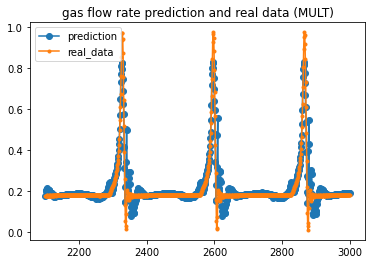

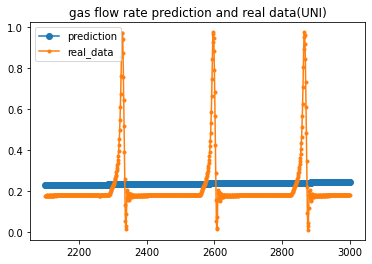

In [11]:
start_ploting = 0
end_ploting = len(test_mult)
## multivariate 
fig,ax = plt.subplots()
ax.set_title('gas flow rate prediction and real data (MULT)')
ax.plot(pred_gas_mult['ds'].iloc[start_ploting:end_ploting], pred_gas_mult['yhat'].iloc[start_ploting:end_ploting], marker="o", label='prediction')
ax.plot(test_mult['ds'].iloc[start_ploting:end_ploting], test_mult['gas(m3/day)'].iloc[start_ploting:end_ploting], marker=".", label='real_data')
ax.legend(loc='upper left')
## Univariate 
fig,ax = plt.subplots()
ax.set_title('gas flow rate prediction and real data(UNI)')
ax.plot(pred_gas_uni['ds'].iloc[start_ploting:end_ploting], pred_gas_uni['yhat'].iloc[start_ploting:end_ploting], marker="o", label='prediction')
ax.plot(test_uni['ds'].iloc[start_ploting:end_ploting], test_uni['gas(m3/day)'].iloc[start_ploting:end_ploting], marker=".", label='real_data')
ax.legend(loc='upper left')

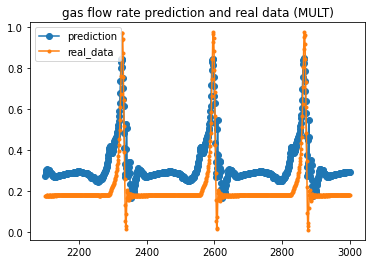

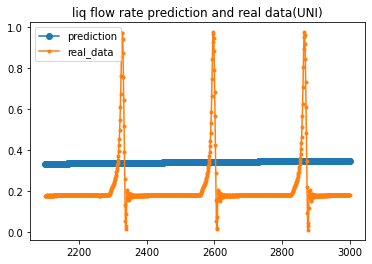

In [12]:
start_ploting = 0
end_ploting = len(test_mult)
## multivariate 
fig,ax = plt.subplots()
ax.set_title('gas flow rate prediction and real data (MULT)')
ax.plot(pred_liq_mult['ds'].iloc[start_ploting:end_ploting], pred_liq_mult['yhat'].iloc[start_ploting:end_ploting], marker="o", label='prediction')
ax.plot(test_mult['ds'].iloc[start_ploting:end_ploting], test_mult['gas(m3/day)'].iloc[start_ploting:end_ploting], marker=".", label='real_data')
ax.legend(loc='upper left')
## Univariate 
fig,ax = plt.subplots()
ax.set_title('liq flow rate prediction and real data(UNI)')
ax.plot(pred_liq_uni['ds'].iloc[start_ploting:end_ploting], pred_liq_uni['yhat'].iloc[start_ploting:end_ploting], marker="o", label='prediction')
ax.plot(test_uni['ds'].iloc[start_ploting:end_ploting], test_uni['gas(m3/day)'].iloc[start_ploting:end_ploting], marker=".", label='real_data')
ax.legend(loc='upper left')

In [29]:
def mse(real, pred):
    return mean_squared_error(real, pred)
# [mse(test_mult['gas(m3/day)'], pred_gas_mult['yhat']), mse(test_uni['gas(m3/day)'], pred_gas_uni['yhat']), mse(test_mult['liquid(m3/day)'], pred_liq_mult['yhat']), mse(test_uni['liquid(m3/day)'], pred_liq_uni['yhat'])]

### The Well dataset:


In [7]:
def read_data(fname, plot_data = False):
    # Read the time series
    datats = read_csv(fname, header=0, dayfirst=True, parse_dates=[0], index_col=0, squeeze=True)  # , date_parser=parser

    headers = list(datats.columns.values)
    headers.insert(0, datats.index.name)

    # Convert data to numpy array
    data = datats.reset_index().values

    # Split data into flow periods, and resample each flow period using a uniform timestep
    dt = np.ediff1d(data[:, 0])
    fpbreak = dttm.timedelta(hours=1)  # Minimal break between flow periods
    dt = dt - fpbreak
    ind = np.where(dt - fpbreak > pd.Timedelta(0))[0]
    ind = np.r_[ind, len(data)-1]

    Nfp = len(ind)  # Number of flow periods
    fp = ['None'] * Nfp
    n0 = 0
    n1 = ind[0]+1
    for n in range(Nfp):
        # Resample each flow period separately
        fpts = datats[n0:n1].resample('T').mean()
        fpts = fpts.interpolate(method='linear')
        # Save the resampled flow period to a list of numpy arrays
        fp[n] = fpts.reset_index().values
        #fp[n] = data[n0:n1,:]
        n0 = n1
        if n+1 < Nfp:
            n1 = ind[n+1] + 1    

    # Get the normalization parameters for all data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(data[:,1:]) # Exclude Datetime from normalization

    # Normalize every flow period
    for n in range(Nfp):
        fp[n][:,1:] = scaler.transform(fp[n][:,1:])

    return fp, headers, scaler


In [8]:
fp,headers, _ = read_data('welltest.csv')

##### Whole day training:

In [43]:
# three to one ratio for training and testing 
df_epochs = np.array(range(5))
df = pd.DataFrame.from_dict(dict(zip(headers, fp[df_epochs[0]].T)))
for i in df_epochs[1:]:
    tmp = pd.DataFrame.from_dict(dict(zip(headers, fp[i].T)))
    df = pd.concat([df,tmp], axis=0)
df = df.rename(columns={'DateTime':'ds'})
### univariate 
# train_uni = pd.concat([df.iloc[:, 0],df.iloc[:, 3:]], axis=1)
### multivariate
# train_mult = df
# test_mult = pd.DataFrame.from_dict(dict(zip(headers, fp[4].T)))
### multivariate
# test_mult = test_mult.rename(columns={'DateTime':'ds'})
### univariate 
# test_uni = pd.concat([test_mult.iloc[:, 0],test_mult.iloc[:, 3:]], axis=1)

In [171]:
train_mult = df.iloc[int(len(fp[0])*0.5):int(len(fp[0])+len(fp[1])+len(fp[2])+0.5*len(fp[3]))]
train_uni = pd.concat([train_mult['ds'], train_mult.iloc[:, 3:]], axis=1)
test_mult= df.iloc[int(len(fp[0])+len(fp[1])+len(fp[2])+0.5*len(fp[3])):int(len(fp[0])+len(fp[1])+len(fp[2])+len(fp[3]))]
test_uni = pd.concat([test_mult['ds'], test_mult.iloc[:, 3:]], axis=1)

In [172]:
test_uni.head()

,ds,Qo (m3/day),Qw (m3/day),Qg (m3/day)
489,2016-01-12 03:21:00,0.217475,0.637137,0.613054
490,2016-01-12 03:22:00,0.191154,0.615344,0.622523
491,2016-01-12 03:23:00,0.154684,0.589243,0.639254
492,2016-01-12 03:24:00,0.19188,0.599993,0.626386
493,2016-01-12 03:25:00,0.215173,0.671763,0.613889


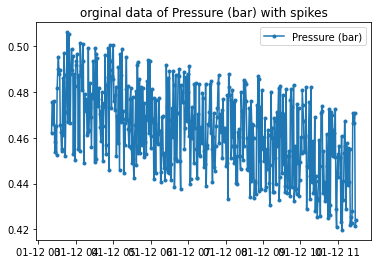

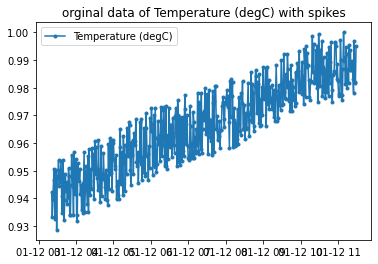

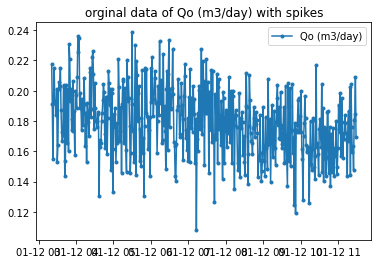

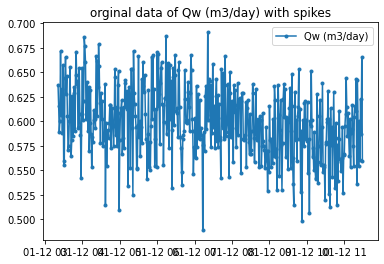

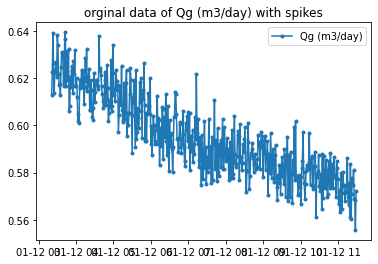

In [173]:
start  = 0
end = len(df)
for i in headers[1:]:
    fig,ax = plt.subplots()
    ax.set_title('orginal data of %s with spikes'%i)
    ax.plot(test_mult['ds'].iloc[start:end], test_mult[i].iloc[start:end], marker=".", label='%s'%i)
    ax.legend()

##### part of day training:

In [82]:
df = pd.DataFrame.from_dict(dict(zip(headers, fp[0].T)))
df = df.rename(columns={'DateTime':'ds'})
train = df.iloc[:int(0.7*len(df))]
test = df.iloc[int(0.7*len(df)):len(df)]

##### Applying:

In [205]:
### Old paramters { daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True, changepoint_prior_scale=0.001, seasonality_prior_scale=0.1, holidays_prior_scale=10.0, seasonality_mode='multiplicative'}
def model_well_fit(train, test, y='Qo (m3/day)', mult=False, gas_change=0.5):
    trainSet = train.rename(columns={y:'y'})
    testSet = test.rename(columns={y:'y'})
    if mult:
        if y == 'Qo (m3/day)':
            ## oil flow rate fitting (multi)
            model_oil_mult = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True, \
                                     changepoint_prior_scale=0.001, seasonality_prior_scale=0.1, \
                                     holidays_prior_scale=10.0, seasonality_mode='multiplicative',\
                                     changepoint_range = 0.6)
            model_oil_mult.add_regressor('Pressure (bar)')
            model_oil_mult.add_regressor('Temperature (degC)')
            model_oil_mult.fit(trainSet)
            oil_test_mult = model_oil_mult.predict(testSet.drop(columns="y"))
            oil_train_mult = model_oil_mult.predict(trainSet.drop(columns="y"))
            return model_oil_mult, oil_test_mult, oil_train_mult
        if y == 'Qw (m3/day)':
            ## water flow rate fitting (multi)
            model_water_mult = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True,\
                                       changepoint_prior_scale=0.001, seasonality_prior_scale=0.1, \
                                       holidays_prior_scale=10.0, seasonality_mode='multiplicative',\
                                       changepoint_range = 0.5)
            model_water_mult.add_regressor('Pressure (bar)')
            model_water_mult.add_regressor('Temperature (degC)')
            model_water_mult.fit(trainSet)
            water_test_mult = model_water_mult.predict(testSet.drop(columns="y"))
            water_train_mult = model_water_mult.predict(trainSet.drop(columns="y"))
            return model_water_mult,water_test_mult, water_train_mult
        ## gas flow rate fitting (multi)
        model_gas_mult = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True,\
                                 changepoint_prior_scale=0.001, seasonality_prior_scale=0.1, \
                                 holidays_prior_scale=10.0, seasonality_mode='additive',\
                                 changepoint_range = gas_change)
        model_gas_mult.add_regressor('Pressure (bar)')
        model_gas_mult.add_regressor('Temperature (degC)')
        model_gas_mult.fit(trainSet)
        gas_test_mult = model_gas_mult.predict(testSet.drop(columns="y"))
        gas_train_mult = model_gas_mult.predict(trainSet.drop(columns="y"))
        return model_gas_mult, gas_test_mult, gas_train_mult
    if y == 'Qo (m3/day)':
            ## oil flow rate fitting (uni)
            model_oil_uni = Prophet()
            model_oil_uni.fit(trainSet)
            oil_test_uni = model_oil_uni.predict(testSet.drop(columns="y"))
            oil_train_uni = model_oil_uni.predict(trainSet.drop(columns="y"))
            return model_oil_uni, oil_test_uni, oil_train_uni
    if y == 'Qw (m3/day)':
        ## water flow rate fitting (uni)
        model_water_uni = Prophet()
        model_water_uni.fit(trainSet)
        water_test_uni = model_water_uni.predict(testSet.drop(columns="y"))
        water_train_uni = model_water_uni.predict(trainSet.drop(columns="y"))
        return model_water_uni,water_test_uni, water_train_uni

    ## gas flow rate fitting (uni)
    model_gas_uni = Prophet()
    model_gas_uni.fit(trainSet)
    gas_test_uni = model_gas_uni.predict(testSet.drop(columns="y"))
    gas_train_uni = model_gas_uni.predict(trainSet.drop(columns="y"))
    return model_gas_uni, gas_test_uni, gas_train_uni

In [207]:
# for i in np.arange(0.4, 0.95, 0.05):
gas_model_mult, gas_ts_mult, gas_tr_mult = model_well_fit(train_mult, test_mult, y='Qg (m3/day)', mult=True, gas_change=0.65)
#     print(mse(gas_ts_mult['yhat'], test_mult['Qg (m3/day)']))

In [193]:
## gas 
gas_model_mult, gas_ts_mult, gas_tr_mult = model_well_fit(train_mult, test_mult, y='Qg (m3/day)', mult=True)
gas_model_uni, gas_ts_uni, gas_tr_uni = model_well_fit(train_uni, test_uni, y='Qg (m3/day)', mult=False)
## oil 
oil_model_mult, oil_ts_mult, oil_tr_mult = model_well_fit(train_mult, test_mult, y='Qo (m3/day)', mult=True)
oil_model_uni, oil_ts_uni, oil_tr_uni = model_well_fit(train_uni, test_uni, y='Qo (m3/day)', mult=False)
## water 
water_model_mult, water_ts_mult, oil_tr_mult = model_well_fit(train_mult, test_mult, y='Qw (m3/day)', mult=True)
water_model_uni, water_ts_uni, oil_tr_uni = model_well_fit(train_uni, test_uni, y='Qw (m3/day)', mult=False)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [194]:
[mse(gas_ts_mult['yhat'], test_mult['Qg (m3/day)']),mse(gas_ts_uni['yhat'], test_uni['Qg (m3/day)']),\
 mse(oil_ts_mult['yhat'], test_mult['Qo (m3/day)']), mse(oil_ts_uni['yhat'], test_uni['Qo (m3/day)']),\
 mse(water_ts_mult['yhat'], test_mult['Qw (m3/day)']), mse(water_ts_uni['yhat'], test_uni['Qw (m3/day)']) ]

[0.0007552917395098713,
 0.005763462060212814,
 0.000503155436551324,
 0.004348807676407132,
 0.0013719801046208789,
 0.011002820451494531]

In [209]:
len(gas_ts_uni)

489

##### Results

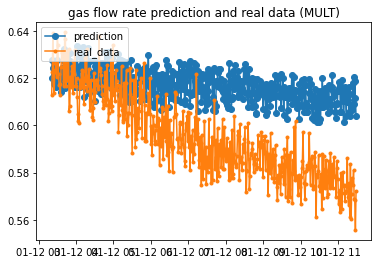

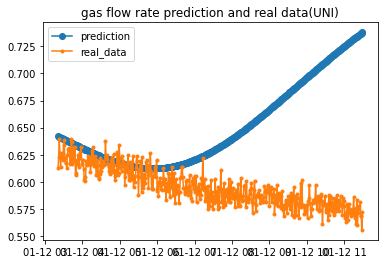

In [208]:
start_ploting = 0
end_ploting = len(test_mult)
## multivariate 
fig,ax = plt.subplots()
ax.set_title('gas flow rate prediction and real data (MULT)')
ax.plot(gas_ts_mult['ds'].iloc[start_ploting:end_ploting], gas_ts_mult['yhat'].iloc[start_ploting:end_ploting], marker="o", label='prediction')
ax.plot(test_mult['ds'].iloc[start_ploting:end_ploting], test_mult['Qg (m3/day)'].iloc[start_ploting:end_ploting], marker=".", label='real_data')
ax.legend(loc='upper left')
## Univariate 
fig,ax = plt.subplots()
ax.set_title('gas flow rate prediction and real data(UNI)')
ax.plot(gas_ts_uni['ds'].iloc[start_ploting:end_ploting], gas_ts_uni['yhat'].iloc[start_ploting:end_ploting], marker="o", label='prediction')
ax.plot(test_uni['ds'].iloc[start_ploting:end_ploting], test_uni['Qg (m3/day)'].iloc[start_ploting:end_ploting], marker=".", label='real_data')
ax.legend(loc='upper left')

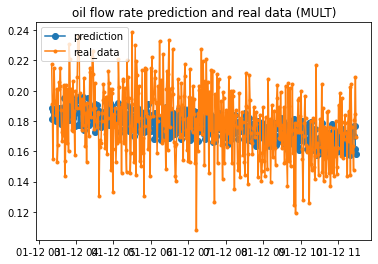

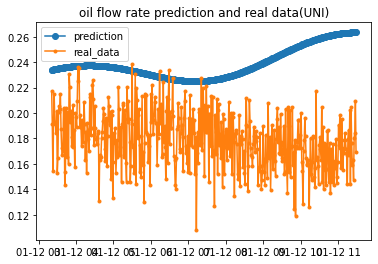

In [190]:
start_ploting = 0
end_ploting = len(test_mult)
## multivariate 
fig,ax = plt.subplots()
ax.set_title('oil flow rate prediction and real data (MULT)')
ax.plot(oil_ts_mult['ds'].iloc[start_ploting:end_ploting], oil_ts_mult['yhat'].iloc[start_ploting:end_ploting], marker="o", label='prediction')
ax.plot(test_mult['ds'].iloc[start_ploting:end_ploting], test_mult['Qo (m3/day)'].iloc[start_ploting:end_ploting], marker=".", label='real_data')
ax.legend(loc='upper left')
## Univariate 
fig,ax = plt.subplots()
ax.set_title('oil flow rate prediction and real data(UNI)')
ax.plot(oil_ts_uni['ds'].iloc[start_ploting:end_ploting], oil_ts_uni['yhat'].iloc[start_ploting:end_ploting], marker="o", label='prediction')
ax.plot(test_uni['ds'].iloc[start_ploting:end_ploting], test_uni['Qo (m3/day)'].iloc[start_ploting:end_ploting], marker=".", label='real_data')
ax.legend(loc='upper left')

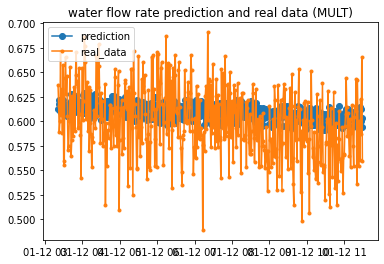

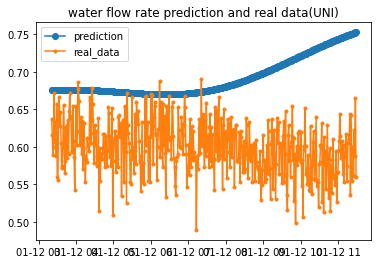

In [191]:
start_ploting = 0
end_ploting = len(test_mult)
## multivariate 
fig,ax = plt.subplots()
ax.set_title('water flow rate prediction and real data (MULT)')
ax.plot(water_ts_mult['ds'].iloc[start_ploting:end_ploting], water_ts_mult['yhat'].iloc[start_ploting:end_ploting], marker="o", label='prediction')
ax.plot(test_mult['ds'].iloc[start_ploting:end_ploting], test_mult['Qw (m3/day)'].iloc[start_ploting:end_ploting], marker=".", label='real_data')
ax.legend(loc='upper left')
## Univariate 
fig,ax = plt.subplots()
ax.set_title('water flow rate prediction and real data(UNI)')
ax.plot(water_ts_uni['ds'].iloc[start_ploting:end_ploting], water_ts_uni['yhat'].iloc[start_ploting:end_ploting], marker="o", label='prediction')
ax.plot(test_uni['ds'].iloc[start_ploting:end_ploting], test_uni['Qw (m3/day)'].iloc[start_ploting:end_ploting], marker=".", label='real_data')
ax.legend(loc='upper left')

## Finding the best parameters

In [148]:
import itertools
param_grid = {  
#     'seasonality_prior_scale': [0.01, 0.1, 1.0],
#     'holidays_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_mode': ['multiplicative', 'additive'],
    'daily_seasonality': [True, False], 
    'weekly_seasonality': [True, False],
    'yearly_seasonality': [True, False], 
    'changepoint_range': [0.5, 0.6,0.7, 0.8, 0.9]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here


In [149]:
len(all_params)

720

In [15]:
from prophet.diagnostics import cross_validation, performance_metrics
# Use cross validation to evaluate all parameters
gas_rmse = []
water_rmse = []
oil_rmse = []
number_iter = 0
# run this for three different 
for params in all_params:
    for i in range(0,3):
        trainSet_param = train_mult
        number_iter+=1
        if i == 0:
            trainSet_param = trainSet_param.rename(columns={'Qo (m3/day)':'y'})
            m_oil = Prophet(**params).add_regressor('Pressure (bar)')\
                        .add_regressor('Temperature (degC)').fit(trainSet_param)  
            df_cv_oil = cross_validation(m_oil,horizon='1 days', initial='3 days', parallel="processes")
            df_p_oil = performance_metrics(df_cv_oil, rolling_window=1)
            oil_rmse.append(df_p_oil['rmse'].values[0])
            print(number_iter)
        if i == 1:
            trainSet_param = trainSet_param.rename(columns={'Qg (m3/day)':'y'})
            m_gas = Prophet(**params).add_regressor('Pressure (bar)')\
                        .add_regressor('Temperature (degC)').fit(trainSet_param)  
            df_cv_gas = cross_validation(m_gas,horizon='1 days', initial='3 days', parallel="processes")
            df_p_gas = performance_metrics(df_cv_gas, rolling_window=1)
            gas_rmse.append(df_p_gas['rmse'].values[0])
            print(number_iter)
        if i == 2:
            trainSet_param = trainSet_param.rename(columns={'Qw (m3/day)':'y'})
            m_water = Prophet(**params).add_regressor('Pressure (bar)')\
                        .add_regressor('Temperature (degC)').fit(trainSet_param)  
            df_cv_water = cross_validation(m_water,horizon='1 days', initial='3 days', parallel="processes")
            df_p_water = performance_metrics(df_cv_water, rolling_window=1)
            water_rmse.append(df_p_water['rmse'].values[0])
            print(number_iter)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22e314e50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


1


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc229541a10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


2


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230146810>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


3


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdea1d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


4


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde2810>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


5


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23011f790>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


6


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22953bc10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


7


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe495d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


8


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22930a950>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


9


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c450>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


10


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb2ced0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


11


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fddf910>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


12


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c110>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


13


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22de83f50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


14


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fadf7d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


15


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2294ff410>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


16


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdb3110>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


17


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22de83f50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


18


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fabec90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


19


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22930aa90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


20


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2301151d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


21


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb08e90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


22


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230146a10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


23


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c550>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


24


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde8e10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


25


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23014ea90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


26


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230115f90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


27


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdb3610>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


28


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230132e90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


29


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe50250>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


30


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230146a10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


31


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde5590>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


32


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde2810>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


33


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fadf510>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


34


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb2cb90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


35


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22953bf50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


36


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fabecd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


37


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb2cd10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


38


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fc031d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


39


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22b4a1c90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


40


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb086d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


41


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fac5450>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


42


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230146e50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


43


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fabec50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


44


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fabed10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


45


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fabefd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


46


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fda8910>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


47


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe50250>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


48


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fda8790>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


49


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd91490>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


50


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22de83f50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


51


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc229517710>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


52


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe49110>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


53


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe503d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


54


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe3c590>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


55


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe31510>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


56


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fac5b90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


57


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8cd90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


58


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23011f790>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


59


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23014e910>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


60


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22bbdf490>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


61


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fddfad0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


62


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22faea810>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


63


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23011f790>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


64


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c110>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


65


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230115090>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


66


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23011f790>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


67


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fddf750>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


68


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22ea80bd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


69


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fc03610>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


70


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23014ec10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


71


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe3c790>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


72


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fda86d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


73


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22bd39a50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


74


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fda8690>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


75


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc229541a10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


76


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe502d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


77


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c0d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


78


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdea050>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


79


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230146dd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


80


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22b4a5690>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


81


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230132f10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


82


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22dfb7690>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


83


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde8dd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


84


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdea1d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


85


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230132f10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


86


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230132f10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


87


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb08650>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


88


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe39110>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


89


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23014e910>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


90


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230146dd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


91


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2301157d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


92


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22930a950>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


93


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fc03610>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


94


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22dfb7690>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


95


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdea050>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


96


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230146910>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


97


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2294f50d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


98


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc229541790>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


99


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22a8c8ad0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


100


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23014ead0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


101


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22953bf50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


102


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdb3c10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


103


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb08e90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


104


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fac5ed0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


105


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe39ed0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


106


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22de83f50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


107


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fc031d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


108


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fac5c50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


109


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde8d90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


110


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22faea950>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


111


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fc031d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


112


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22de877d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


113


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde29d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


114


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde8d90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


115


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdbb1d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


116


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8ce10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


117


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb2cc50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


118


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c150>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


119


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23014ec10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


120


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22dfb7690>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


121


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc229541790>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


122


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22faea7d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


123


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2301159d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


124


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fda8a10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


125


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22de83f50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


126


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe39ed0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


127


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22953bc10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


128


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23011f790>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


129


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb2ccd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


130


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe39ed0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


131


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22bbdf490>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


132


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc229517610>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


133


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb2cc50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


134


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22faeafd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


135


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22bd39d50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


136


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fac5510>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


137


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdb3490>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


138


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdea050>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


139


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe502d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


140


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230149bd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


141


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2301469d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


142


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc229517510>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


143


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22afee710>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


144


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22afee710>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


145


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe49710>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


146


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe39110>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


147


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd91d10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


148


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230132f10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


149


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c110>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


150


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c150>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


151


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde8d90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


152


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd91d10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


153


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fac5550>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


154


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb2cf90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


155


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23014e6d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


156


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fadf5d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


157


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd91490>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


158


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230132f10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


159


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230132f10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


160


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8cd90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


161


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc229541790>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


162


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c0d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


163


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2295175d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


164


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23014e3d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


165


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdb3550>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


166


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230132d90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


167


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde5590>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


168


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22ea80bd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


169


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe0f5d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


170


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe39ed0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


171


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd91d10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


172


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22bd39d50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


173


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22953bf50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


174


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fda8990>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


175


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230132f10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


176


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2301151d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


177


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fddfb10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


178


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22930a950>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


179


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdb3350>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


180


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22d838310>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


181


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe502d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


182


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc229541a10>


183


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb2cd10>


184


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdbb1d0>


185


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23014ec10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


186


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fadfa10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


187


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230146a50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


188


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2301490d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


189


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe398d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


190


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c550>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


191


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fadfcd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


192


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fc03610>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


193


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fadf7d0>


194


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe49550>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


195


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fac5a10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


196


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c0d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


197


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23014e290>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


198


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22afee710>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


199


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22afee710>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


200


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23014e1d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


201


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22bd39a50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


202


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fc031d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


203


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fabee10>


204


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22930aa90>


205


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22930a950>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


206


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde8dd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


207


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22930aa90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


208


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fabef10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


209


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fabee90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


210


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22de877d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


211


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fac5c50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


212


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdb3190>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


213


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2295419d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


214


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe49810>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


215


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c0d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


216


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230115550>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


217


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22d838310>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


218


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23014e150>


219


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe0fd10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


220


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22faea5d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


221


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c550>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


222


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fda8c10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


223


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe49550>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


224


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdea1d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


225


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdb3350>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


226


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde8dd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


227


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe0fd90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


228


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe495d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


229


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fadffd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


230


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c5d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


231


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe0f650>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


232


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2301158d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


233


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe312d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


234


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230146810>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


235


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22bbdf490>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


236


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdea1d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


237


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fabecd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


238


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb08650>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


239


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230115450>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


240


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe31f90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


241


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb086d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


242


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd91d10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


243


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fddfa90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


244


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde8e10>


245


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22941da90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


246


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdea1d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


247


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2294ff410>


248


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc229541410>


249


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc229541790>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


250


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230149790>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


251


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23014ef50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


252


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde5590>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


253


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c5d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


254


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde29d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


255


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fddff50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


256


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb086d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


257


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230146d50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


258


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22b4a1c90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


259


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c450>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


260


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c0d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


261


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde8d90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


262


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22b4a1c90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


263


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe39110>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


264


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22953bf50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


265


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fabefd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


266


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde29d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


267


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22b4a5690>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


268


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde8e10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


269


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe0fb10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


270


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2295175d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


271


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22ea80bd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


272


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22953bc10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


273


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230132d90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


274


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fabed50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


275


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb2ccd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


276


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22941da90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


277


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22afee710>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


278


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22bd39a10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


279


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdbb1d0>


280


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230115f90>


281


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde5590>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


282


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdb3490>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


283


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde2810>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


284


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fddf850>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


285


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22d838310>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


286


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23014e9d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


287


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb086d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


288


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fabed50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


289


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fabedd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


290


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23011f790>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


291


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb08f90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


292


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fabec50>


293


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2301158d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


294


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230132e90>


295


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdb3110>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


296


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb2cc10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


297


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230115590>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


298


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22953bf50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


299


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fac51d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


300


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22e314e50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


301


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdbb1d0>


302


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fadfb10>


303


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdbb1d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


304


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22930aa90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


305


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe50250>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


306


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22930aa90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


307


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde2810>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


308


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c5d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


309


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fabef10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


310


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230146f10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


311


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22a8c87d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


312


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22bd39a50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


313


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb2c5d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


314


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fac56d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


315


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fac58d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


316


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe0f090>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


317


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc229541a10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


318


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22a8c8d90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


319


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb08e90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


320


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230132d90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


321


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22a8c8890>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


322


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22930a050>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


323


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22bc64490>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


324


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdb34d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


325


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe3c910>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


326


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230146dd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


327


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe39ed0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


328


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22ea80bd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


329


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb086d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


330


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22de83f50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


331


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2294ff410>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


332


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23014e150>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


333


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8cd90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


334


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22bd39d50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


335


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fabef10>


336


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe50250>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


337


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc229541410>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


338


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2301469d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


339


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc229541410>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


340


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fddffd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


341


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22a8c8dd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


342


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdea1d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


343


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdb3090>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


344


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb08650>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


345


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8ce10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


346


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe49fd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


347


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb2cc50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


348


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb08f90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


349


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fadfa50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


350


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe50250>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


351


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe49590>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


352


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230146dd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


353


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22a8c87d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


354


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fda8a90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


355


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22dfb7690>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


356


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde5590>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


357


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2294f50d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


358


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2294f50d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


359


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe39ed0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


360


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230132f10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


361


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230146e50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


362


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2295419d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


363


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe50250>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


364


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22bd39a50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


365


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22e314e50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


366


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc229541790>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


367


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230132d90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


368


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2301469d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


369


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb2cb50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


370


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb086d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


371


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde8dd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


372


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22941da90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


373


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22930a050>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


374


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22afee710>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


375


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23014e910>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


376


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe0fbd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


377


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde5590>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


378


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc229517410>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


379


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22930a050>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


380


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fabee50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


381


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22bd39d50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


382


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb08650>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


383


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fddf810>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


384


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb2cb50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


385


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c0d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


386


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230146b10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


387


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fadf8d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


388


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb086d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


389


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd91d10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


390


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fac51d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


391


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230146810>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


392


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230146d10>


393


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22b4a5690>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


394


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2294ff410>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


395


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc229541410>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


396


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fabed10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


397


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde29d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


398


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c450>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


399


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fabed90>


400


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22ea0de90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


401


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe39ed0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


402


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fac5550>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


403


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb2ccd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


404


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc229541790>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


405


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe31f50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


406


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230146810>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


407


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde2810>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


408


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22bd39d50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


409


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe49810>


410


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe0f550>


411


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8ce10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


412


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2301154d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


413


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb2c5d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


414


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb08650>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


415


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8cd90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


416


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb2c5d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


417


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22ea80bd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


418


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22e314e50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


419


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb2cc50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


420


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2294f50d0>


421


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fda8990>


422


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22941da90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


423


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fddfed0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


424


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230115790>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


425


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc229541a10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


426


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe0fdd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


427


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22bd39d50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


428


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22de877d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


429


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c0d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


430


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23014e5d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


431


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230115690>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


432


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22de877d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


433


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2295419d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


434


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22de877d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


435


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2294ff410>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


436


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230149d50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


437


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fac5810>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


438


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22b4a1c90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


439


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22ea0de90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


440


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23011f790>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


441


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23011f790>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


442


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22930a950>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


443


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c5d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


444


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22de877d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


445


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe49550>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


446


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc229541a10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


447


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22ea80bd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


448


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe49550>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


449


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe502d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


450


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd91d10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


451


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8ce10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


452


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe503d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


453


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22dfb7690>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


454


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fabee50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


455


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe502d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


456


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe31f50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


457


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc229517410>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


458


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c110>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


459


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fac5450>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


460


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23014ed10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


461


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22e314e50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


462


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb08e90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


463


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230149b50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


464


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fddfd90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


465


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22e314e50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


466


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc229517950>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


467


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdb3790>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


468


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230146a50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


469


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230132d90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


470


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230146e50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


471


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22b4a5690>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


472


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde8e10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


473


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe3c710>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


474


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22bd39a10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


475


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23011f790>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


476


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fabef10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


477


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22afee710>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


478


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb2cc50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


479


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc229517650>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


480


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fabef90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


481


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22953bf50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


482


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fddf9d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


483


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22930aa90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


484


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22a8c87d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


485


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22930a050>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


486


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fadf610>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


487


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde29d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


488


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22a8c88d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


489


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fda8bd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


490


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe0f190>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


491


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdea050>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


492


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230146a50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


493


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb2cc50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


494


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22ea0de90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


495


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22941da90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


496


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe3c450>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


497


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdb3110>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


498


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230146dd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


499


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22d838310>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


500


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2294ff410>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


501


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230132d90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


502


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23014e5d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


503


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230132f10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


504


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2295178d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


505


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22dfb7690>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


506


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fda8150>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


507


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c550>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


508


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe39ed0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


509


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb2cc50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


510


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fda8a90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


511


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fc031d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


512


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c110>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


513


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdb31d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


514


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde8dd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


515


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fabee50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


516


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe50250>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


517


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdb31d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


518


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdb30d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


519


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23011f790>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


520


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23011f790>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


521


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fabef10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


522


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdb38d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


523


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde29d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


524


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230149650>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


525


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230132f10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


526


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fc03610>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


527


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22ea80bd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


528


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb08650>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


529


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23014e3d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


530


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc229517850>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


531


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23014e150>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


532


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2294f50d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


533


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230146a50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


534


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22bc64490>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


535


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c150>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


536


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe50250>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


537


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230146910>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


538


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22ea0de90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


539


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdb34d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


540


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fc031d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


541


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde2810>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


542


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe3c190>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


543


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe31b10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


544


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe49110>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


545


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22e314e50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


546


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd91d10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


547


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fabef90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


548


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22bc64490>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


549


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c150>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


550


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22953bf50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


551


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22bbdf490>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


552


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb086d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


553


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fac5390>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


554


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230115690>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


555


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8cd90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


556


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c450>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


557


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde8dd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


558


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23014e6d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


559


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fda8990>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


560


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230132d90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


561


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd91490>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


562


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd8c150>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


563


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdb31d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


564


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fabef10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


565


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdbb1d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


566


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22d838310>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


567


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdea1d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


568


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2294ff410>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


569


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2294ff410>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


570


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc23014ef50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


571


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe503d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


572


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fc03610>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


573


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe502d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


574


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22ea0de90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


575


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb08e90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


576


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22930aa90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


577


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fda8150>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


578


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc229541790>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


579


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fadf950>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


580


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2295419d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


581


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230146910>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


582


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22ea0de90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


583


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22ea0de90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


584


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fddfad0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


585


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fd91d10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


586


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230132e90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


587


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdb3190>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


588


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22eb2cc90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


589


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fdb3350>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


590


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc2295178d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


591


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe502d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


592


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fe493d0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


593


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22bd39a50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


594


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22bd39a50>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


595


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc230146d10>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


596


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22930a950>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


597


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22fde8dd0>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


598


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22b4a1c90>
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


599


INFO:prophet:Making 10 forecasts with cutoffs between 2016-01-09 03:57:00 and 2016-01-13 15:57:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fc22953bc10>


600


In [17]:
tuning_results = pd.DataFrame(all_params)
tuning_results['oil'] = oil_rmse
tuning_results['water'] = water_rmse
tuning_results['gas'] = gas_rmse

In [19]:
tuning_results.head()

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,oil,water,gas
0,0.001,0.01,0.01,multiplicative,0.067371,0.156404,0.255230
1,0.001,0.01,0.01,additive,0.070658,0.130993,0.197500
2,0.001,0.01,0.10,multiplicative,0.090877,0.167579,0.261917
3,0.001,0.01,0.10,additive,0.071579,0.129935,0.191399
4,0.001,0.01,1.00,multiplicative,0.098422,0.167272,0.261649


In [20]:
tuning_results.to_csv('tuning.csv')

In [22]:
tuning_results[tuning_results['oil'] == tuning_results['oil'].min()]

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,oil,water,gas
0,0.001,0.01,0.01,multiplicative,0.067371,0.156404,0.25523


In [23]:
tuning_results[tuning_results['water'] == tuning_results['water'].min()]

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,oil,water,gas
15,0.001,0.1,1.0,additive,0.072029,0.129395,0.19476


In [24]:
tuning_results[tuning_results['gas'] == tuning_results['gas'].min()]

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,oil,water,gas
5,0.001,0.01,1.0,additive,0.071721,0.131141,0.184528
